In [4]:
%matplotlib inline
%run ../../code/grammar
%run ../../code/gsc2
# A lot of changes have been made. The LF-SS-PF example won't work with this new version. 
# In this example, we used a non-default quantization scheme; roles compete with each other for each filler. 

In [5]:
# Create role encodings
roles_syl_num = ['1', '2']    # first vs. second syllable
roles_syl_pos = ['onset', 'coda']  # onset vs. coda

# Create encodings of those roles (distributed representation) with specific pairwise similarity structure.
# dp (dot product similarity): if it is set to a scalar, all pairwise similarity is set to the number.
# The similarity of a symbol with itself is set to 1.
R_syl_num = encode_symbols(len(roles_syl_num), reptype='dist', dp=0.25)
R_syl_pos = encode_symbols(len(roles_syl_pos), reptype='dist', dp=0.1)

print(R_syl_num)
print(R_syl_pos)

# Each matrix contains a vector representation of each symbol in a column vector. (1d-array in the program)
# For example, the vector representation of role '1' is 
print(R_syl_num[:, 0])   # Note that the index starts at 0 in Python.

# We set the dot product similarity between '0' and '1' to 0.25 in the above.
# Check the pairwise similarity between roles '1' and '2'.
print( np.dot(R_syl_num[:, 0], R_syl_num[:, 1]) )
#print( R_syl_num[:,0].dot(R_syl_num[:,1]) )   # another way to compute the dot product of two vectors (1d-arrays in Python)

[[ 0.97256341  0.46839064]
 [-0.23263582  0.88352092]]
[[ 0.99909321  0.05755803]
 [ 0.04256569  0.99834167]]
[ 0.97256341 -0.23263582]
0.250000989554


In [6]:
# Create recursive roles

# Please pay attention to the argument order. To create a binding of sym1[x]sym2, use compute_TPmat(sym2, sym1).
R, Rinv = compute_TPmat(R_syl_num, R_syl_pos) 
roles = bind(roles_syl_pos, roles_syl_num, sep='-')
print(roles)
print(R)

# Now check the similarity between composite roles
# Similarity btw 'onset-1' and 'onset-2' should be equal to similarity between '1' and '2'.
print(np.dot(R[:,0], R[:,2])) # 0.25
# Similarity btw 'onset-1' and 'coda-1' should be equal to similarity between 'onset' and 'coda'.
print(np.dot(R[:,0], R[:,1])) # 0.1

['onset-1', 'coda-1', 'onset-2', 'coda-2']
[[ 0.9716815   0.05597884  0.46796591  0.02695964]
 [ 0.04139784  0.97095058  0.01993737  0.4676139 ]
 [-0.23242486 -0.01339006  0.88271975  0.05085373]
 [-0.00990231 -0.23225003  0.03760768  0.88205575]]
0.250000760488
0.100000848743


In [7]:
# Create encodings of fillers with specific similarity structure.
fillers = ['k', 'g', 'n', 's']
dpmat_of_fillers = [[ 1.0,  0.5,  0.1,  0.1],
                    [ 0.5,  1.0,  0.1,  0.1],
                    [ 0.1,  0.1,  1.0, 0.25],
                    [ 0.1,  0.1, 0.25,  1.0]]
dpmat_of_fillers = np.asarray(dpmat_of_fillers)
F = encode_symbols(len(fillers), reptype='dist', dp=dpmat_of_fillers)

print(F)

[[-0.19399866  0.45472254  0.75144219  0.0952406 ]
 [ 0.17465256 -0.11045298  0.36662012  0.94518169]
 [ 0.89256394  0.34556258  0.3703334  -0.16217618]
 [ 0.36768151  0.81339604 -0.40469433  0.2669451 ]]


In [8]:
net = GscNet(filler_names=fillers, role_names=roles, reptype_r='dist', reptype_f='dist', 
             dp_f = dpmat_of_fillers, R=R, F=F, beta = 3, T_init = 0.001, T_decay_rate=0.01,
             q_fun = 'plinear', q_max=100, q_rate=0.1)

In [9]:
curr_input = ['s/onset-1', 'g/coda-1', 'n/onset-2', 'k/coda-2']
net.reset()  # will unclamp and clear all external input; reset simulation parameters, q and T; set the state to a random point inside a unit hypercube.
net.set_input(curr_input, 1.0)
#net.all_grid_points()   # In this way, you can create a set of all grid points (sorted by harmony) after creating the network instance.

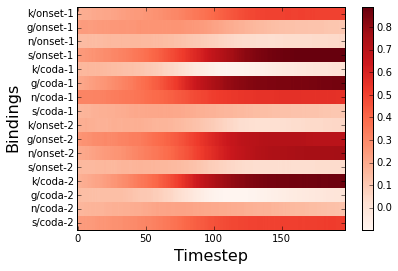

In [10]:
net.set_init_state(mu=0.2, sd=0.05)   # Reset an initial state. Each state variable will be sampled randomly from a normal distribution N(mu, sd^2).
                                      # In this model, it seems important to set the initial state near the origin. 
net.run(10000, plot=True, tol=0.001, ema_factor=0.01, norm_ord=np.inf)

In [11]:
print('input:  ', curr_input)
print('output: ', net.read_grid_point(disp=False))

input:   ['s/onset-1', 'g/coda-1', 'n/onset-2', 'k/coda-2']
output:  ['s/onset-1', 'g/coda-1', 'n/onset-2', 'k/coda-2']


In [12]:
net.rt

196

In [13]:
np.random.seed(100)
nrep = 2000
gp_all = [None] * nrep   # storage for the end state (grid point) in each run.
rt_all = np.zeros(nrep)  # storage for RT.
net.q_rate = 0.2

In [14]:
input1 = ['s/onset-1', 'g/coda-1', 'n/onset-2', 'k/coda-2']
for rep_ind in range(nrep):
    # progress bar
    if ((rep_ind+1) % 10) == 0:
        print('[%04d]' % (rep_ind+1), end="")
        if ((rep_ind+1) % 100) == 0:
            print('')
    net.reset()          # reset() method will clear external input and unclamp all bindings.
    net.set_input(input1, 1.0)   # Need to set input every time.
    net.all_grid_points()
    net.set_init_state(mu=0.2, sd=0.05) # CHECK
    net.run(10000, tol=0.001, ema_factor=0.01, norm_ord=np.inf)
    gp_all[rep_ind] = net.read_grid_point(disp=False)
    rt_all[rep_ind] = net.rt

[0010][0020][0030][0040][0050][0060][0070][0080][0090][0100]
[0110][0120][0130][0140][0150][0160][0170][0180][0190][0200]
[0210][0220][0230][0240][0250][0260][0270][0280][0290][0300]
[0310][0320][0330][0340][0350][0360][0370][0380][0390][0400]
[0410][0420][0430][0440][0450][0460][0470][0480][0490][0500]
[0510][0520][0530][0540][0550][0560][0570][0580][0590][0600]
[0610][0620][0630][0640][0650][0660][0670][0680][0690][0700]
[0710][0720][0730][0740][0750][0760][0770][0780][0790][0800]
[0810][0820][0830][0840][0850][0860][0870][0880][0890][0900]
[0910][0920][0930][0940][0950][0960][0970][0980][0990][1000]
[1010][1020][1030][1040][1050][1060][1070][1080][1090][1100]
[1110][1120][1130][1140][1150][1160][1170][1180][1190][1200]
[1210][1220][1230][1240][1250][1260][1270][1280][1290][1300]
[1310][1320][1330][1340][1350][1360][1370][1380][1390][1400]
[1410][1420][1430][1440][1450][1460][1470][1480][1490][1500]
[1510][1520][1530][1540][1550][1560][1570][1580][1590][1600]
[1610][1620][1630][1640]

In [15]:
# Less ideal than 4-filler cases.
freqtab = np.zeros(len(net.gpset))
for ii, gp in enumerate(gp_all):
    freqtab[net.gpset.index(gp)] += 1
probtab = freqtab/nrep
print("Accuracy: %.5f" % probtab[0])

Accuracy: 0.81250


In [16]:
def fseq(gpset):
    if not isinstance(gpset[0], list):
        gpset = [gpset]
    return [''.join([bb.split('/')[0] for bb in gp]) for ii, gp in enumerate(gpset)]

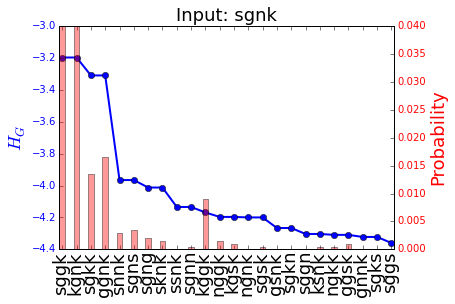

In [17]:
net.all_grid_points()    # Create all grid points (sorted by H_0 (grammar harmony) in a decreasing order)
# Ignore the highest one (correct responses)
n_highest = 25
yy = net.gpset_gh[1:n_highest]
yy_prob = probtab[1:n_highest]

fig, ax1 = plt.subplots()
ax1.plot(yy, 'o-', linewidth=2)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('$H_G$', color='b', fontsize=18)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
labels = [','.join(gp) for gp in net.gpset[1:n_highest]]
labels = fseq(net.gpset[1:n_highest])  # simplify labels
ax1.set_xticks(np.arange(len(yy)))
ax1.set_xticklabels(labels, rotation=90, fontsize=18)
ax1.set_title('Input: ' + fseq(curr_input)[0], fontsize=18)

ax2 = ax1.twinx()
ax2.bar(np.arange(n_highest-1), yy_prob, width=0.4, color='r', alpha=0.4, align='center')
ax2.set_ylabel('Probability', color='r', fontsize=18)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_ylim([0, 0.04])
plt.show()